AI - TP3_8

Bastien SAUVAT et Bastien FAISANT

# Exercise 3 : Mini-project : Image to text description

### Image Caption Generator using Flickr Dataset

#### Imports modules

In [50]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer, TFAutoModelForSequenceClassification, BlipForConditionalGeneration, TFBlipForConditionalGeneration, TFAutoModel

In [3]:
BASE_DIR = '.\\kaggle\\input\\flickr8k'
WORKING_DIR = '.\\kaggle\\working'

#### Extract Images Features

In [4]:
model = VGG16() #load vgg16 model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

****

#### Load the Captions Data

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, image_caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = ' '.join(image_caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

#### Preprocessing Text Data

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[Â-Za-z]+', '')
            caption = caption.replace('\s+', ' ')
            caption = '<start>' + ' '.join([word for word in caption.split() if len(word)>1]) + '<end>'
            captions[i] = caption

In [11]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
clean(mapping)

In [13]:
mapping['1000268201_693b08cb0e']

['<start>child in pink dress is climbing up set of stairs in an entry way<end>',
 '<start>girl going into wooden building<end>',
 '<start>little girl climbing into wooden playhouse<end>',
 '<start>little girl climbing the stairs to her playhouse<end>',
 '<start>little girl in pink dress going into wooden cabin<end>']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['<start>child in pink dress is climbing up set of stairs in an entry way<end>',
 '<start>girl going into wooden building<end>',
 '<start>little girl climbing into wooden playhouse<end>',
 '<start>little girl climbing the stairs to her playhouse<end>',
 '<start>little girl in pink dress going into wooden cabin<end>',
 '<start>black dog and spotted dog are fighting<end>',
 '<start>black dog and tri-colored dog playing with each other on the road<end>',
 '<start>black dog and white dog with brown spots are staring at each other in the street<end>',
 '<start>two dogs of different breeds looking at each other on the road<end>',
 '<start>two dogs on pavement moving toward each other<end>']

In [17]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8483

In [19]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

33

#### Train Test Split

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.90)
split
train = image_ids[:split]
test = image_ids[split:]

In [21]:
# Create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

                

#### Model Creation

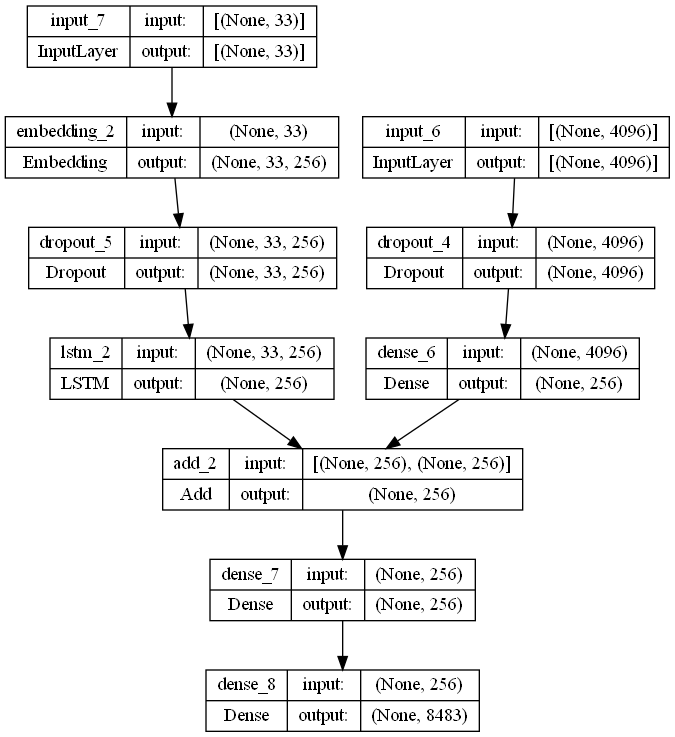

In [24]:
# encoder model
# image feature layer
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequuence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [25]:
#train the model
epochs = 15
batch_size = 64
steps = len(train)//batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)



113/113 [==============================] - 372s 3s/step - loss: 2.4657


In [26]:
model.save(WORKING_DIR+'\\best_model.h5')

#### Generate Captions for the Image

In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [28]:
# generate caption for image
def predict_caption(model, image, tokenizer, max_length):
    in_text = '<start>'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text = in_text + ' ' + word
        if word == '<end>':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_caption = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_caption)
    predicted.append(y_pred)

# calculate BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

#### Visualize the Results

In [29]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # image_name = ""
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, 'Images', image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('Actual Captions')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('Predicted Caption')
    print(y_pred)
    plt.imshow(image)


Actual Captions
<start>black dog and spotted dog are fighting<end>
<start>black dog and tri-colored dog playing with each other on the road<end>
<start>black dog and white dog with brown spots are staring at each other in the street<end>
<start>two dogs of different breeds looking at each other on the road<end>
<start>two dogs on pavement moving toward each other<end>
Predicted Caption
<start> two dogs play with each other in the grass end end end end end end end end end end end end end end end end end end end end end end end end


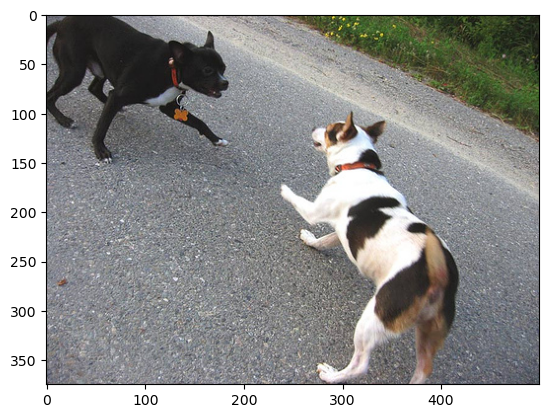

In [30]:
generate_caption('1001773457_577c3a7d70.jpg')

Actual Captions
<start>little girl covered in paint sits in front of painted rainbow with her hands in bowl<end>
<start>little girl is sitting in front of large painted rainbow<end>
<start>small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it<end>
<start>there is girl with pigtails sitting in front of rainbow painting<end>
<start>young girl with pigtails painting outside in the grass<end>
Predicted Caption
<start> the little girl in the pigtails is sitting in front of rainbow rainbow painting end end end of the rainbow end end end of the rainbow end end of the rainbow end end


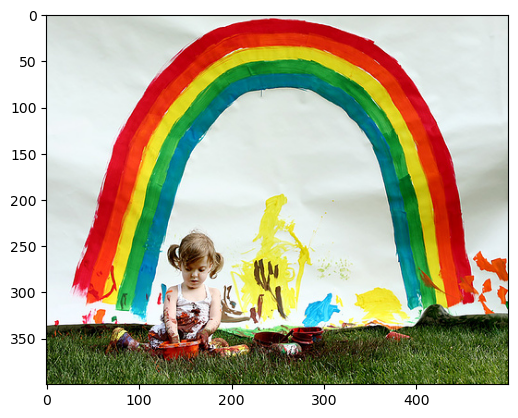

In [31]:
generate_caption('1002674143_1b742ab4b8.jpg')

Actual Captions
<start>man in hat is displaying pictures next to skier in blue hat<end>
<start>man skis past another man displaying paintings in the snow<end>
<start>person wearing skis looking at framed pictures set up in the snow<end>
<start>skier looks at framed pictures in the snow next to trees<end>
<start>man on skis looking at artwork for sale in the snow<end>
Predicted Caption
<start> man wearing skis displaying framed pictures end end end end end end end end end end end end end end end end end end end end end end end end end end end


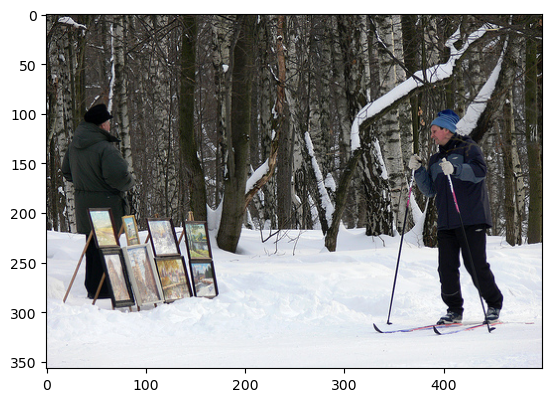

In [32]:
generate_caption('101669240_b2d3e7f17b.jpg')

### Utilisation de la bibliothethque Huggingface transformers avec un modèle pré-entrainé

In [1]:
from transformers import pipeline

In [2]:
captioner = pipeline("image-to-text",model="Salesforce/blip-image-captioning-base")

tf_model.h5:   0%|          | 0.00/990M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBlipForConditionalGeneration.

All the layers of TFBlipForConditionalGeneration were initialized from the model checkpoint at Salesforce/blip-image-captioning-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBlipForConditionalGeneration for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

In [3]:
captioner("https://huggingface.co/datasets/Narsil/image_dummy/resolve/main/parrots.png")

c:\Users\fst09\anaconda3\envs\py35env\lib\site-packages\transformers\generation\tf_utils.py:838: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'two birds are standing next to each other birds'}]

In [4]:
captioner("https://images.pokemontcg.io/det1/2_hires.png")

[{'generated_text': 'a card with a picture of a bird in a hat'}]

In [7]:
captioner("https://i.redd.it/mt1p2undiwo31.jpg")

c:\Users\fst09\anaconda3\envs\py35env\lib\site-packages\transformers\generation\tf_utils.py:838: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'a woman in a pink dress and a man in a suit'}]

In [10]:
captioner("https://images.pokemontcg.io/det1/1_hires.png")

[{'generated_text': 'a card with a picture of a fish'}]

In [54]:
import pandas as pd
import torch
from PIL import Image
import requests
from transformers import BlipProcessor, BlipForConditionalGeneration, AutoTokenizer
from transformers import TFBlipForConditionalGeneration

In [55]:
# Load data from csv file
csv_file_path = "./kaggle/input/FoodImages/food_dataset.csv"
image_folder_path = "./kaggle/input/FoodImages/images"

In [56]:
data = pd.read_csv(csv_file_path)
data["Title"].fillna("", inplace=True)
data["Ingredients"].fillna("", inplace=True)


In [57]:
tokenizer = AutoTokenizer.from_pretrained("Salesforce/blip-image-captioning-base")

In [59]:
max_length = 256 
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = TFBlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

All model checkpoint layers were used when initializing TFBlipForConditionalGeneration.

All the layers of TFBlipForConditionalGeneration were initialized from the model checkpoint at Salesforce/blip-image-captioning-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBlipForConditionalGeneration for predictions without further training.


In [60]:
inputs = []
labels = []
max_length = 256

for index, row in data.iterrows():
    image_path = image_folder_path + "/" + row["Image_Name"]
    title = row["Title"]
    ingredients = row["Ingredients"]

    # Text pre-processing
    text_input = "Title: " + title + " Ingredients: " + ingredients
    tokenized_input = tokenizer(text_input, return_tensors="tf", padding="max_length", max_length=max_length, truncation=True)

    inputs.append({"image_path": image_path, "text_input": tokenized_input})
    labels.append(tokenized_input)

In [38]:
# Conversion to TensorFlow tensors
image_paths = tf.convert_to_tensor([x["image_path"] for x in inputs])
text_inputs = tf.concat([x["text_input"]["input_ids"] for x in inputs], axis=0)
labels = tf.concat([x["text_input"]["input_ids"] for x in inputs], axis=0)

In [39]:
# Creating the TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": text_inputs, "image_paths": image_paths}, {"labels": labels}))
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size=16)

In [47]:

# Loading the pre-trained model
# model = TFAutoModelForSeq2SeqLM.from_pretrained("Salesforce/blip-image-captioning-base")
# model = TFAutoModelForSequenceClassification.from_pretrained("Salesforce/blip-image-captioning-base")
model = TFBlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

All model checkpoint layers were used when initializing TFBlipForConditionalGeneration.

All the layers of TFBlipForConditionalGeneration were initialized from the model checkpoint at Salesforce/blip-image-captioning-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBlipForConditionalGeneration for predictions without further training.


In [48]:
# Fine-tuning the model on the dataset
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss)
model.fit(dataset, epochs=3)

Epoch 1/3


TypeError: in user code:

    File "c:\Users\fst09\anaconda3\envs\py35env\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\fst09\anaconda3\envs\py35env\lib\site-packages\transformers\modeling_tf_utils.py", line 1043, in run_call_with_unpacked_inputs  *
        return func(self, **unpacked_inputs)

    TypeError: tf__call() got an unexpected keyword argument 'image_paths'


In [ ]:
# Saving the fine-tuning model
model.save_pretrained("./kaggle/working/fine_tuned_food_captioning_model")

In [51]:
model = TFAutoModel.from_pretrained("Salesforce/blip-image-captioning-base")

Some layers from the model checkpoint at Salesforce/blip-image-captioning-base were not used when initializing TFBlipModel: ['text_decoder', 'vision_model']
- This IS expected if you are initializing TFBlipModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBlipModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['blip']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:

# URL de l'image à utiliser
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

# Texte conditionnel pour la génération de légende
text = "a photography of"
inputs = tokenizer(raw_image, text, return_tensors="tf", padding=True)

# Génération de la légende conditionnelle
output = model.generate(**inputs)
decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
print(decoded_output)

NameError: name 'Image' is not defined

In [1]:
from datasets import load_dataset 

dataset = load_dataset("ybelkada/football-dataset", split="train")

In [2]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 6
})

In [3]:
dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=722x360>,
 'text': "Benzema after Real Mardid's win against PSG"}

In [4]:
dataset[0]["text"]

"Benzema after Real Mardid's win against PSG"

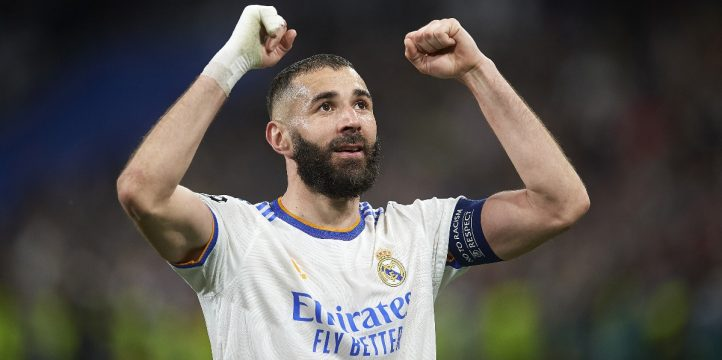

In [5]:
dataset[0]["image"]

In [6]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [7]:
len(dataset)

6

In [7]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [8]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [9]:
len(train_dataset)

6

In [10]:
len(train_dataloader)

3

In [39]:
from datasets import load_dataset
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, BlipForConditionalGeneration
import json
import os

In [40]:
# Load data from csv file
csv_file_path = "./kaggle/input/FoodImages/dataset/food_dataset.csv"
image_folder_path = "./kaggle/input/FoodImages/images"
root = "./kaggle/input/FoodImages/"

In [41]:
data = load_dataset("./kaggle/input/FoodImages/dataset/", split="train")

In [42]:
data

Dataset({
    features: ['Unnamed: 0', 'Title', 'Ingredients', 'Instructions', 'Image_Name', 'Cleaned_Ingredients'],
    num_rows: 13501
})

In [43]:
# Créer un fichier JSONL contenant les informations sur les images et les textes
captions = []
for row in data:
    if(row["Image_Name"] == "#NAME?"):
        continue
    caption = {"file_name": row["Image_Name"] + ".jpg", "text": row["Title"]}
    captions.append(caption)



In [44]:
captions[0]

{'file_name': 'miso-butter-roast-chicken-acorn-squash-panzanella.jpg',
 'text': 'Miso-Butter Roast Chicken With Acorn Squash Panzanella'}

In [45]:
# Créer un Dataset personnalisé pour charger les images et les textes
class CustomDataset(Dataset):
    def __init__(self, texts, image_folder, processor):
        self.texts = texts
        self.image_folder = image_folder
        self.processor = processor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.texts[idx]['file_name'])
        image = Image.open(img_name).convert('RGB')
        text = self.texts[idx]['text']

        encoding = self.processor(images=image, text=text, padding="max_length", return_tensors="pt")
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [46]:
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [47]:
# Créer une instance du Dataset personnalisé
train_dataset = CustomDataset(captions, image_folder_path, processor)

# Utiliser un DataLoader pour charger les données en lots
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=5000)

In [50]:
len(train_dataset)

13471

In [51]:
len(train_dataloader)

3

In [52]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0


KeyError: 'input_ids'

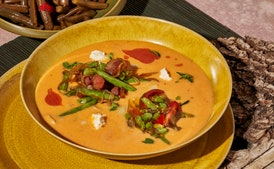

In [44]:
# load image
image = train_dataset[50]['image']
image

In [49]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

miso - butter roast chicken with panzanella


In [46]:
train_dataset[50]['text']

'Summer Bean Soup With Tomato Brown Butter'

In [43]:
train_dataset[0]['text']

'Miso-Butter Roast Chicken With Acorn Squash Panzanella'

In [18]:
count = 0

images = []
texts = []

for index, row in enumerate(data):
    if(row["Image_Name"] == "#NAME?"):
        continue
    image_path = image_folder_path + "/" + row["Image_Name"] + ".jpg"
    # print("id=" + str(index) + "     image_path=" + image_path)

    with Image.open(image_path) as img:
        # Text pre-processing
        title = row["Title"]
        # ingredients = row["Ingredients"]

        # if title is None or ingredients is None:
        #     count += 1
        #     continue

        images.append(img.copy())  # Using img.copy() to avoid issues with closing the original image
        texts.append(title)
            

    # try:
    #     img = Image.open(image_path)

    #     # Text pre-processing
    #     title = row["Title"]

    #     # if title is None:
    #     #     count += 1
    #     #     continue


    #     images.append(img)
    #     texts.append(title)

    #     # tokenized_input = tokenizer(text_input, return_tensors="tf", padding="max_length", max_length=max_length, truncation=True)
    # except (FileNotFoundError, OSError) as e:
    #     count += 1
    #     # print(f"Error loading image for index {index}: {e}")
    #     continue

print(f"Number of images not found: {count}")

Number of images not found: 0


In [21]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, images, texts, processor):
        self.images = images
        self.texts = texts
        self.processor = processor

    def __len__(self):
        return 2

    def __getitem__(self, idx):
        image = self.images[idx]
        text = self.texts[idx]
        encoding = self.processor(images=image, text=text, padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [30]:
train_dataset = ImageCaptioningDataset(images, texts, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

NameError: name 'ImageCaptioningDataset' is not defined